# Sentence Mapper

In [223]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
from rich import print
from datasets import load_dataset


from src.pipeline import SentenceMapperPipeline
from src.visualization import SentenceMapperVisualizer
from src.sentence_processor import SentenceProcessor
from src.map_reduce_summarizer import MapReduceSummarizer

# Suppress langchain text splitter warnings
logging.getLogger('langchain_text_splitters.base').setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Some Data

For this example, we will use one report from the **GovReports dataset**, which is a long document summarization dataset, with about 19.5k reports published by the U.S. Government Accountability Office (GAO) and Congressional Research Service (CRS).

They cover researches on a broad range of national policy issues, including health care, education, national security, economics, and the environment.


Reference: https://arxiv.org/pdf/2104.02112

## Multi-LexSum

Is a collection of 9,280 such legal case summaries. It presents a challenging multi-document summarization task given the long length of the source documents, often exceeding two hundred pages per case. Experts—lawyers and law students—are trained to follow carefully created guidelines, and their work is reviewed by an additional expert to ensure quality.

Reference: Shen et al. 2022 https://arxiv.org/pdf/2206.10883

In [258]:
# Download one sample from the train split.

split = "train"
index = 0

govreport = load_dataset("ccdv/govreport-summarization", split=f"{split}[:50]")
report = govreport[index]["report"]
reference_summary = govreport[index]["summary"]
print(f"Report:\n{report[:500]}...\n")
print(f"Reference Summary:\n{reference_summary[:500]}...\n")

#multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")

# Download multi_lexsum locally and load it as a Dataset object 

#example["sources"] # A list of source document text for the case

Report:
The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the 
structure—active duty military personnel, reservists, defense contractors, host nation military and civilian 
personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian 
personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the
countries of Bosnia-Herzegovina, Croatia, and Hung...

Reference Summary:
As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed departmen...

## Sentence Processor

Splits the full document into sentences, then for each sentence builds a centered context window of complete surrounding sentences (excluding the target sentence itself) up to a character budget. Cosine similarity is
computed between the sentence embedding and its context embedding, giving a clean representativeness signal without self-overlap artifacts.

It requires 2 parameters: 

- context_budget: Maximum character budget for the context window surrounding each sentence (default: 2048)
- min_sentence_length: Minimum sentence length in characters. Shorter sentences are merged (default: 256)
 

SentenceProcessor uses model2vec to get embeddings super fast. 

Some domains may use specific abbreviations or prefixes that can confuse the sentence splitter. These prefixes can be passed in custom_parameters, so they are do not end sentences.


For the GovReports dataset, we can add some common abbreviations:
- **U.S.** (United States)
- **H.R.** (House Resolution)
- **H.Rept.** (House Report)
- **P.L.** (Public Law)
- **S.** (Senate bill)

In [259]:
custom_parameters = {
    "prefixes": [
        "H.R", "H.Rept", "S", "P.L", "Rep", "Sen", "S.Rept",
        "U.S", "N.Y", "Calif", "U.N"
    ],
    "additional_replacements": {
        "U.": "U<prd>",
        "S.": "S<prd>",
        "U.S.": "U<prd>S<prd>",
        "U.S.A.": "U<prd>S<prd>A<prd>",
        "i.e.": "i<prd>e<prd>",
        "e.g.": "e<prd>g<prd>",
        "Ph.D.": "Ph<prd>D<prd>",
        "et al.": "et<prd>al<prd>",
    }
}

# Initialize processor with custom splitter for government reports
processor = SentenceProcessor(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters
)

visualizer = SentenceMapperVisualizer()

Total sentences: 259

Total tokens: 11023

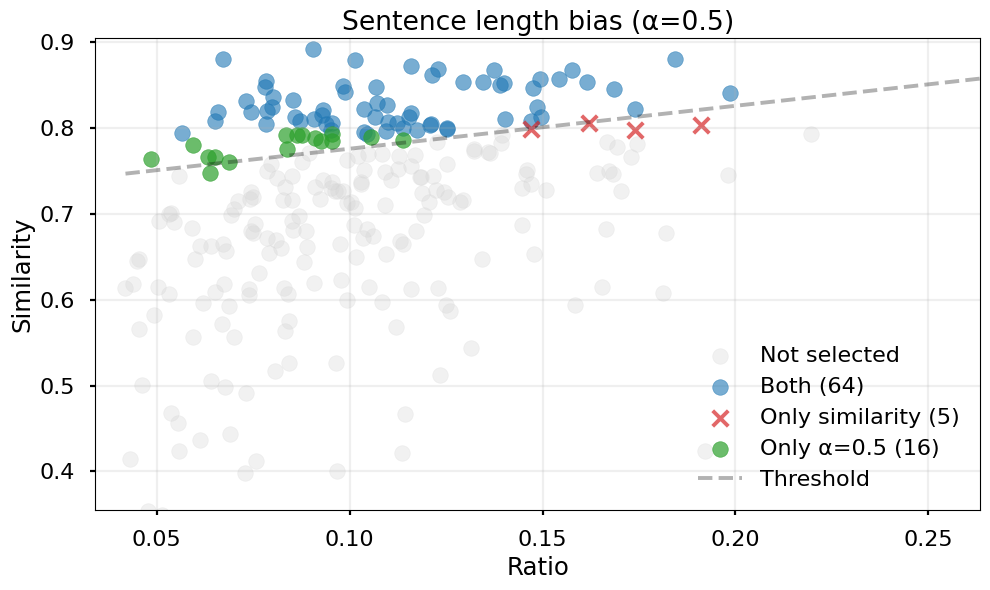

In [296]:
features = processor.compute_document_features(text=report)

print(f"Total sentences: {len(features['similarities'])}")
print(f"Total tokens: {features['total_tokens']}")



fig = SentenceMapperVisualizer.plot_similarity_vs_ratio(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    length_bias=0.5,
    title="Sentence length bias (α=0.5)",
    save_path="data/img/similarity_vs_ratio_plot.png"
)

plt.show()

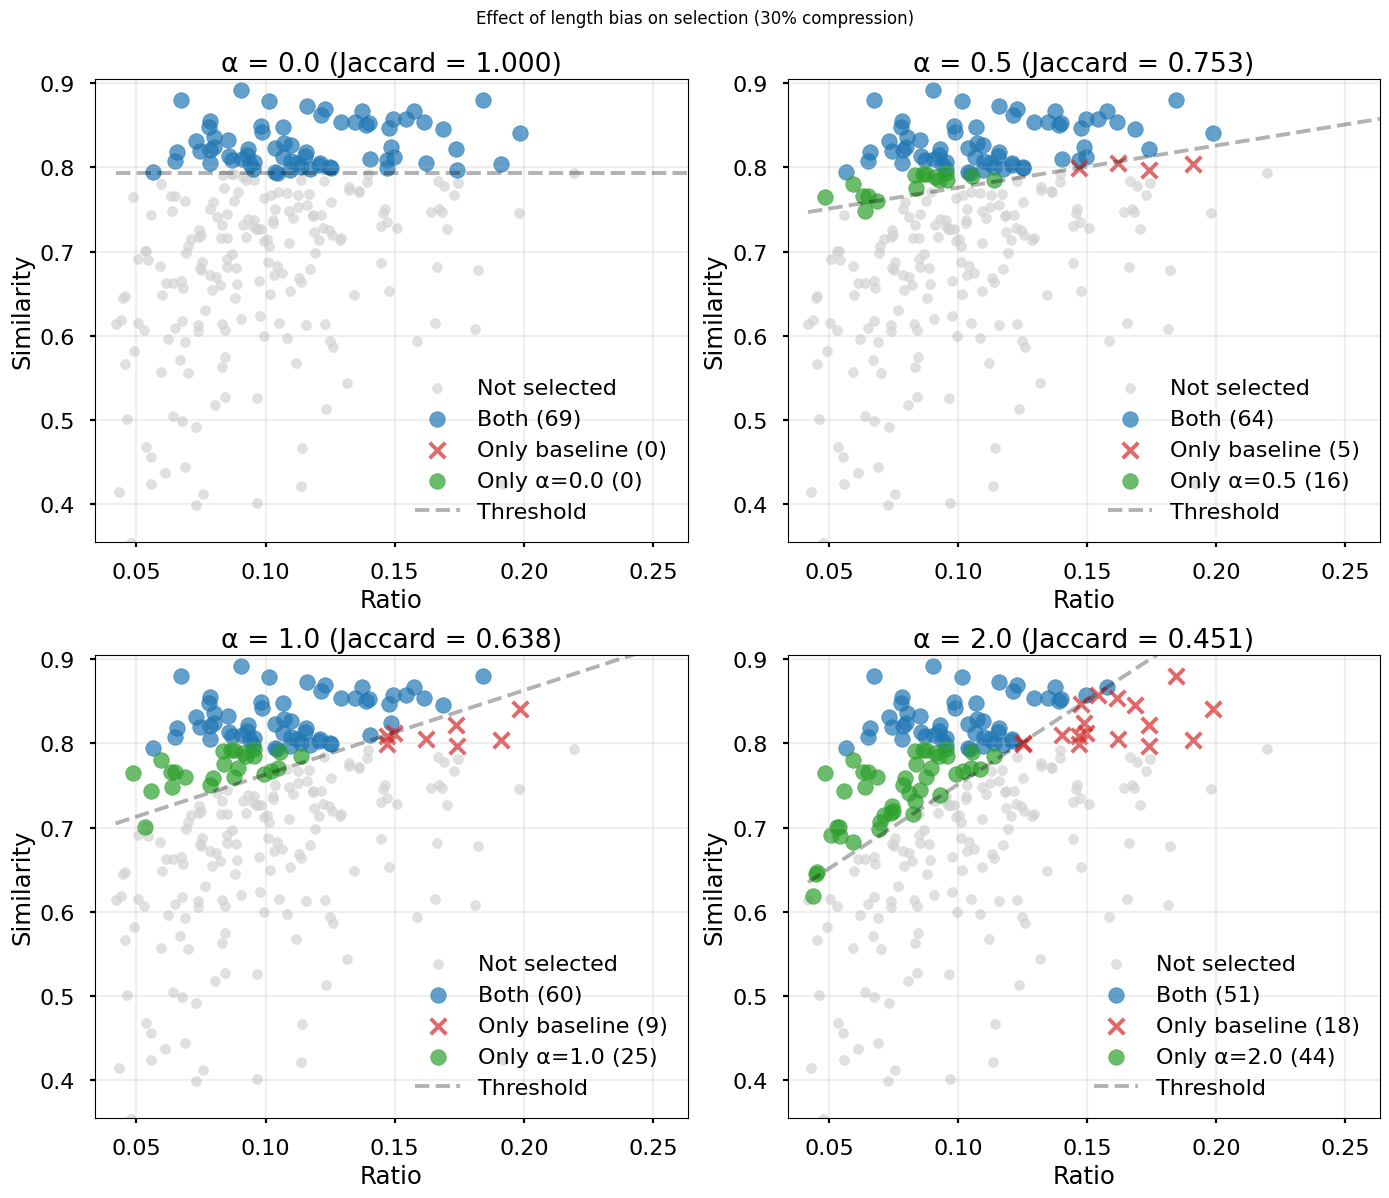

In [295]:
# 2x2 grid comparing different alpha values at 30% compression
fig = visualizer.plot_similarity_vs_ratio_multiple_alphas(
    similarities=features['similarities'],
    ratios=features['ratios'],
    tokens=features['tokens'],
    objective_percentage=0.3,
    alphas=[0.0, 0.5, 1.0, 2.0],
    title="Effect of length bias on selection (30% compression)",
    save_path="data/img/similarity_vs_ratio_plot_multiple_alphas.png"
)
plt.show()

## Scoring & Selection

Each sentence is scored by:

```
score = similarity - α × ratio
```

Where `α` (length_bias, default 0.5) is a linear penalty that mildly favours shorter sentences at equal similarity. With `α = 0`, this is pure similarity ranking.

The additive form composes naturally with future bias terms (e.g. `+ β × query_similarity` for semantic-biased extraction).

Sentences are ranked by score and greedily selected until the token budget is reached.

## Extract the best sentences

`SentenceMapperPipeline.process_document` computes features, scores, and selects the top sentences to fill the token budget.

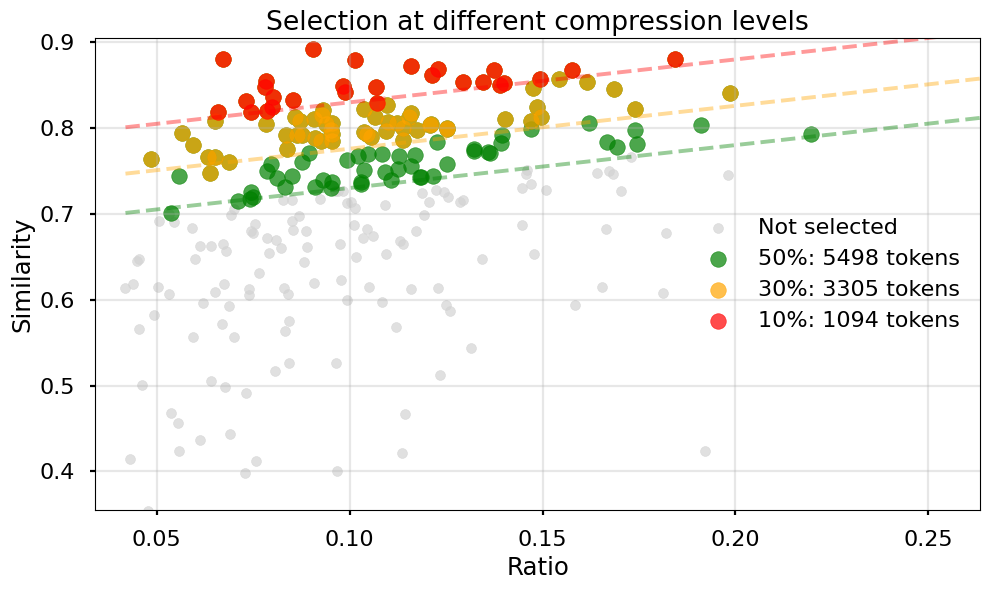

In [293]:
# Initialize pipeline with custom splitter
pipeline = SentenceMapperPipeline(
    embedding_model_name="minishlab/potion-base-8M",
    context_budget=2048,
    min_sentence_length=256,
    custom_parameters=custom_parameters,
    length_bias=0.5,
)

objective_percentages = [0.1, 0.3, 0.5]

results = []
for pct in objective_percentages:
    r = pipeline.process_document(text=report, objective_percentage=pct)
    results.append(r)

# Show selections at different compression levels
SentenceMapperVisualizer.plot_similarity_vs_ratio_multiple_objectives(
    similarities=features['similarities'],
    ratios=features['ratios'],
    results=results,
    objective_percentages=objective_percentages,
    title="Selection at different compression levels"
)


See the selected sentences highlighted in the HTML file.

In [297]:
result = results[1]  # Get the result for the 30% objective
percentage = objective_percentages[1]

SentenceMapperVisualizer.export_highlighted_text(
    sentences=features['sentences'],
    mask=result['mask'],
    output_path=f"data/html/{split}_{index}_{percentage*100:.0f}.html"
)

In [298]:
# Display the first 3 chunks with highlighted sentences
SentenceMapperVisualizer.display_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    title=f"Selected Sentences ({percentage*100:.0f}% compression)",
    dark_mode=True,
    max_display_tokens=500
)

In [300]:
# Interactive plot — baseline vs length-biased with sentence hover
visualizer = SentenceMapperVisualizer()

fig = visualizer.plot_similarity_vs_ratio_interactive(
    similarities=features["similarities"],
    ratios=features["ratios"],
    tokens=features["tokens"],
    sentences=result["sentences"],
    objective_percentage=percentage,
    length_bias=result["length_bias"],
    title=f"Baseline vs α={result['length_bias']} ({percentage:.0%} target)",
)

## Map - Reduce Summarization

Traditional map-reduce is token expensive. Summarizing section into intermediate summaries (map step), and then generating the final summary is expensive.

After extracting the most information-dense sentences, we can pass them to a LLM to generate a summary spanning the whole document. 
LLM's nowadays are intelligent enough to understand the document even with 70-80% missing context. 


In [271]:
summarizer = MapReduceSummarizer(
    summarize_model="gpt-4.1",
    judge_model="gpt-5"
)

In [272]:
llm_summary = summarizer.summarize_with_llm(text=result["selected_text"])

In [273]:
# Compare with the human reference summary
print("\n[bold]Generated Summary:[/bold]\n")
print(llm_summary)
print("\n[bold]Reference Summary:[/bold]\n")
print(reference_summary)

Generated Summary:

The Department of Defense (DOD) established the emergency-essential program in 1985 to ensure that federal civilian
employees would deploy to combat zones and perform critical support functions. In response to the heightened 
deployment of federal civilian personnel to combat theaters such as Afghanistan and Iraq, DOD implemented force 
health protection and surveillance policies to assess and mitigate health risks. These policies require pre- and 
post-deployment medical assessments, completion and review of health forms within 30 days of deployment, and 
administration of necessary immunizations. However, an examination of 3,771 deployment records at selected 
component locations revealed some gaps in compliance: 52 records lacked documentation of the required 
pre-deployment health assessments, and 285 lacked proof of at least one required immunization. While the Army 
generally maintained comprehensive records, other components were less consistent. Moreover, DOD had not 
established procedures to ensure full implementation of these policies, nor had it mandated tracking or reporting 
of civilian personnel locations and movements in operational theaters. The absence of requirements to forward 
completed deployment health assessments to the Army Medical Surveillance Activity further hindered the integration 
of civilian health data within the Defense Medical Surveillance System.

Recognizing these shortcomings, DOD officials acknowledged the need for more complete and centralized deployment 
information. In August 2006, the Office of the Under Secretary of Defense for Personnel and Readiness issued 
revised policy guidance aimed at addressing deficiencies in force health protection and surveillance. The new 
guidance required DOD components to report location-specific and health data for all deployed personnel, including 
civilians, but did not establish an oversight or quality assurance mechanism to ensure effective implementation—a 
gap that had previously been corrected for military personnel in response to legislative mandates and Government 
Accountability Office recommendations.

Medical care for deployed DOD federal civilians is provided through the military’s four-level medical system. The 
Federal Employees' Compensation Act (FECA) covers injury or illness claims, requiring claimants to substantiate 
eligibility for workers' compensation. A review of seven out of 83 FECA claims indicated that DOD civilians 
received care consistent with DOD medical treatment policies, both in theater and after return to the United 
States, through military or civilian treatment facilities.

Regarding compensation, DOD federal civilian personnel deployed to support contingency operations are eligible for 
an array of special pays and benefits, often distinct in type and amount from those available to their military 
counterparts. Both groups receive special deployment-related pays, but the structure and value can differ. For 
example, civilians may receive post (hardship) differential and danger pay, each totaling 35 percent of their base 
salaries, as well as premium pays such as overtime and night differentials not available to military personnel. 
Modeled scenarios demonstrated that, in certain circumstances, total compensation for deployed civilians can exceed
that of military personnel.

When it comes to disability, both groups are eligible for compensation and retirement benefits if injured during 
deployment, but the calculation methods differ. Civilian benefits are based on salary and dependent status, while 
military benefits provided by the Department of Veterans Affairs (VA) are based on the severity of the disability 
and number of dependents. For severe injuries and lower salaries, VA benefits for military personnel may be higher,
but for less severe injuries and higher salaries, civilian benefits typically surpass those for military personnel.
Civilians must meet minimum service requirements (five years under CSRS or 1

Reference Summary:

As the Department of Defense (DOD) has expanded its involvement in overseas military operations, it has grown 
increasingly reliant on its federal civilian workforce to support contingency operations. The Senate Armed Services
Committee required GAO to examine DOD's policies concerning the health care for DOD civilians who deploy in support
of contingency operations in Afghanistan and Iraq. GAO analyzed over 3,400 deployment-related records for deployed 
federal civilians and interviewed department officials to determine the extent to which DOD has established and the
military services and defense agencies (hereafter referred to as DOD components) have implemented (1) force health 
protection and surveillance policies and (2) medical treatment policies and procedures for its deployed federal 
civilians. GAO also examined the differences in special pays and benefits provided to DOD's deployed federal 
civilians and military personnel. DOD has established force health protection and surveillance policies to assess 
and reduce or prevent health risks for its deployed federal civilian personnel, but it lacks procedures to ensure 
implementation. Our review of over 3,400 deployment records at eight component locations found that components 
lacked documentation that some federal civilian personnel who deployed to Afghanistan and Iraq had received, among 
other things, required pre- and post-deployment health assessments and immunizations. These deficiencies were most 
prevalent at Air Force and Navy locations, and one Army location. As a larger issue, DOD lacked complete and 
centralized data to readily identify its deployed federal civilians and their movement in theater, further 
hindering its efforts to assess the overall effectiveness of its force health protection and surveillance 
capabilities. In August 2006, DOD issued a revised policy which outlined procedures that are intended to address 
these shortcomings. However, these procedures are not comprehensive enough to ensure that DOD will know the extent 
to which its components are complying with existing health protection requirements. In particular, the procedures 
do not establish an oversight and quality assurance mechanism for assessing the implementation of its force health 
protection and surveillance requirements. Until DOD establishes a mechanism to strengthen its force health 
protection and surveillance oversight, it will not be effectively positioned to ensure compliance with its 
policies, or the health care and protection of deployed federal civilians. DOD has also established medical 
treatment policies for its deployed federal civilians which provide those who require treatment for injuries or 
diseases sustained during overseas hostilities with care that is equivalent in scope to that provided to active 
duty military personnel under the DOD military health system. GAO reviewed a sample of seven workers' compensation 
claims (out of a universe of 83) filed under the Federal Employees' Compensation Act by DOD federal civilians who 
deployed to Iraq. GAO found in three cases where care was initiated in theater, that the affected civilians had 
received treatment in accordance with DOD's policies. In all seven cases, DOD federal civilians who requested care 
after returning to the United States had, in accordance with DOD's policies, received medical examinations and/or 
treatment for their deployment-related injuries or diseases through either military or civilian treatment 
facilities. DOD provides certain special pays and benefits to its deployed federal civilians, which generally 
differ in type and/or amount from those provided to deployed military personnel. For example, both civilian and 
military personnel are eligible to receive disability benefits for deployment-related injuries; however, the type 
and amount of these benefits vary, and some are unique to each group. Further, while the survivors of deceased 
federal civilian and military personnel ge

In [274]:
from src.map_reduce_summarizer import calculate_rouge_scores

print(f"Input length: {len(report)} characters")
print(f"Extracted sentences lenght: {len(result["selected_text"])}")
print(f"Reference summary length: {len(reference_summary)} characters")
print(f"Generated summary lenght: {len(llm_summary)}")

rouge_scores = calculate_rouge_scores(reference_summary, llm_summary)

print(f"  ROUGE-1 F1: {rouge_scores['rouge1']:.4f}")
print(f"  ROUGE-2 F1: {rouge_scores['rouge2']:.4f}")
print(f"  ROUGE-L F1: {rouge_scores['rougeL']:.4f}")


Input length: 62042 characters

Extracted sentences lenght: 19419

Reference summary length: 4074 characters

Generated summary lenght: 5970

ROUGE-1 F1: 0.5932

ROUGE-2 F1: 0.1915

ROUGE-L F1: 0.2273

## LLM-Judge and Future Work

We can use a LLM-as-a-Judge to identify the most salient differences.

In the future, SentenceMapper will support the use of a "semantic-bias". A list of keywords or keyphrases that
are relevant for the dataset. They should increase the likelihood of sentences containing them to be extracted.

The LLM-as-a-Judge model can also suggest guidelines for the summarizer.
This infomation can be used to improve the summarization prompt.

Evaluate a small sample of summaries of the dataset, to get a representative list of both, keywords and guideance. Implementing both strategies should improve the quality of the summaries.

In [275]:
judge_evaluation = summarizer.judge_with_llm(
        generated_summary=llm_summary, 
        reference_summary=reference_summary,
        compression_ratio=30,
    )

print(judge_evaluation["differences"])
print(judge_evaluation["semantic_bias"])
print(judge_evaluation["high-level guidance"])
print(judge_evaluation["overall_score"])

Both summaries cover DOD’s reliance on civilians, force health protection/surveillance policies, compliance gaps, 
the August 2006 policy update lacking oversight/QA, civilian medical care consistency with policy, and differences 
in civilian vs military pays/benefits. The generated summary adds background (emergency-essential program), 
detailed figures (e.g., 3,771 records; specific counts of missing immunizations/assessments), and program mechanics
(four-level medical system, Army Medical Surveillance Activity) not in the reference. It omits the reference’s 
emphasis on where deficiencies were most prevalent (Air Force, Navy, one Army location) and the explicit lack of a 
comprehensive oversight/quality assurance mechanism as the central unresolved issue. It generalizes some medical 
findings (doesn’t note the “three in-theater” cases) and injects specific pay amounts and modeled scenarios not 
present in the reference. It also ends abruptly, reducing completeness.

[
    'force health protection and surveillance',
    'pre- and post-deployment health assessments',
    'immunizations and medical readiness',
    'oversight and quality assurance',
    'compliance and documentation gaps',
    'centralized data and tracking of deployed civilians',
    'policy changes and implementation',
    'equivalence of medical treatment for civilians and military',
    'workers’ compensation for deployed civilians',
    'disability and survivor benefits comparisons'
]

Prioritize the report’s core evaluation questions, major findings, and unresolved gaps over background context. 
Clearly distinguish policy as written from implementation and compliance evidence, and surface any oversight or 
quality assurance mechanisms (or lack thereof). Capture essential quantitative scope (sample sizes, time frames) 
only insofar as it supports key findings. When comparing groups (e.g., civilians vs military), summarize the nature
and direction of differences without overfitting to narrow dollar amounts unless central to the conclusions. Avoid 
adding specifics not grounded in the source extracts, and be cautious about inferring program mechanics or 
processes. Note limitations such as data gaps or tracking deficiencies that affect the agency’s ability to ensure 
compliance. Ensure the summary is complete and not truncated.

6

## A/B Comparison: Multiplicative Formula (historical)

ROUGE comparison of the **old multiplicative** formula `score = similarity / ratio^α` at 30% compression:
- **α = 0.1** (length-biased) vs **α = 0** (pure similarity)

*Note: The pipeline now uses the additive formula `score = similarity - α × ratio` (see cells below).*

In [206]:
from rouge_score import rouge_scorer
import pandas as pd

def compare_length_bias(
    dataset,
    pipeline,
    objective_percentage: float = 0.3,
    biases: list[float] = [0.0, 0.1],
):
    """Compare different length_bias values on a dataset."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    
    records = []
    
    for i, example in enumerate(dataset):
        report = example["report"]
        reference = example["summary"]
        
        row = {"doc": i}
        
        for alpha in biases:
            result = pipeline.process_document(
                report,
                objective_percentage=objective_percentage,
                length_bias=alpha,
            )
            scores = scorer.score(reference, result["selected_text"])
            prefix = f"a{alpha}"
            row[f"{prefix}_tokens"] = int(result["selected_tokens"])
            row[f"{prefix}_rouge1"] = scores["rouge1"].fmeasure
            row[f"{prefix}_rouge2"] = scores["rouge2"].fmeasure
            row[f"{prefix}_rougeL"] = scores["rougeL"].fmeasure
        
        records.append(row)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")
    
    return pd.DataFrame(records)

In [207]:
df = compare_length_bias(
    dataset=govreport,
    pipeline=pipeline,
    objective_percentage=0.3,
    biases=[0.0, 0.1],
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [208]:
# Summary statistics
summary = pd.DataFrame({
    "α = 0 (similarity only)": {
        "ROUGE-1": df["a0.0_rouge1"].mean(),
        "ROUGE-2": df["a0.0_rouge2"].mean(),
        "ROUGE-L": df["a0.0_rougeL"].mean(),
        "Avg tokens": df["a0.0_tokens"].mean(),
    },
    "α = 0.1 (length bias)": {
        "ROUGE-1": df["a0.1_rouge1"].mean(),
        "ROUGE-2": df["a0.1_rouge2"].mean(),
        "ROUGE-L": df["a0.1_rougeL"].mean(),
        "Avg tokens": df["a0.1_tokens"].mean(),
    },
})
summary["Δ (α=0.1 − α=0)"] = summary["α = 0.1 (length bias)"] - summary["α = 0 (similarity only)"]

print(f"Comparison over {len(df)} reports at 30% compression\n")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

# Win rates
print(f"\n--- Win rates (α=0.1 > α=0) ---")
for metric in ["rouge1", "rouge2", "rougeL"]:
    bias_wins = (df[f"a0.1_{metric}"] > df[f"a0.0_{metric}"]).sum()
    sim_wins = (df[f"a0.1_{metric}"] < df[f"a0.0_{metric}"]).sum()
    ties = (df[f"a0.1_{metric}"] == df[f"a0.0_{metric}"]).sum()
    print(f"  {metric.upper():8s}: α=0.1 wins {bias_wins}, α=0 wins {sim_wins}, ties {ties}")

Comparison over 50 reports at 30% compression

α = 0 (similarity only)  α = 0.1 (length bias)  Δ (α=0.1 − α=0)
ROUGE-1                      0.3465                 0.3475           0.0010
ROUGE-2                      0.1639                 0.1652           0.0014
ROUGE-L                      0.1609                 0.1638           0.0029
Avg tokens                2580.9600              2581.5800           0.6200

--- Win rates (α=0.1 > α=0) ---

ROUGE1  : α=0.1 wins 23, α=0 wins 27, ties 0

ROUGE2  : α=0.1 wins 26, α=0 wins 24, ties 0

ROUGEL  : α=0.1 wins 32, α=0 wins 18, ties 0

## Additive vs Multiplicative Scoring

Compare the current multiplicative formula `score = similarity / ratio^α` with an additive alternative `score = similarity - α × ratio`.

The additive form is more intuitive (direct penalty in similarity-point units) and composes naturally with future bias terms (e.g. `+ β × query_similarity`).

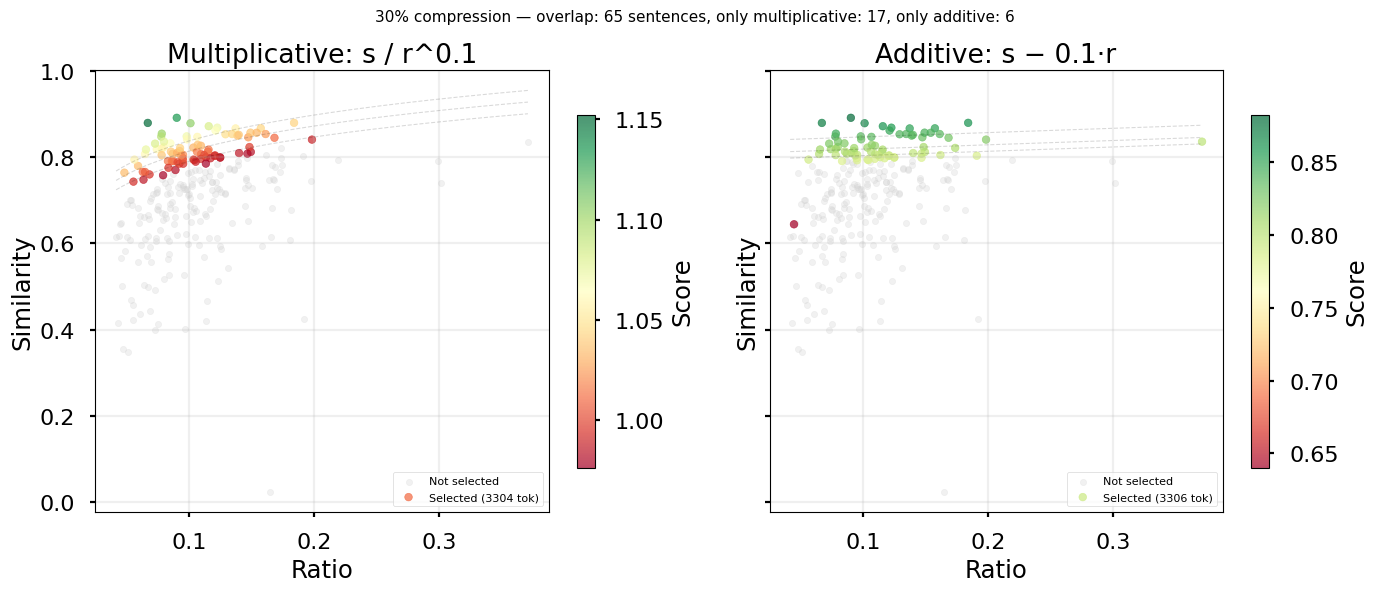

In [209]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.1
objective_percentage = 0.3

similarities = result['similarities']
ratios = result['ratios']
tokens = result['tokens']
total_tokens = int(np.sum(tokens))
objective_tokens = total_tokens * objective_percentage

# --- Scoring formulas ---
safe_ratios = np.maximum(ratios, 1e-9)
scores_multiplicative = similarities / np.power(safe_ratios, alpha)  # current
scores_additive = similarities - alpha * ratios                       # proposed

# --- Greedy selection for each ---
def greedy_select(scores, tokens, budget):
    mask = np.zeros(len(scores), dtype=bool)
    current = 0
    for idx in np.argsort(-scores):
        if current + tokens[idx] > budget:
            continue
        mask[idx] = True
        current += tokens[idx]
    return mask

mask_mult = greedy_select(scores_multiplicative, tokens, objective_tokens)
mask_add = greedy_select(scores_additive, tokens, objective_tokens)

# --- Visualisation ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, mask, scores, title in [
    (axes[0], mask_mult, scores_multiplicative, f"Multiplicative: s / r^{alpha}"),
    (axes[1], mask_add, scores_additive, f"Additive: s − {alpha}·r"),
]:
    # Unselected
    ax.scatter(
        ratios[~mask], similarities[~mask],
        color='lightgrey', alpha=0.3, s=20, label='Not selected',
    )
    # Selected, coloured by score
    sc = ax.scatter(
        ratios[mask], similarities[mask],
        c=scores[mask], cmap='RdYlGn', alpha=0.7, s=30,
        label=f'Selected ({int(np.sum(tokens[mask]))} tok)',
    )
    plt.colorbar(sc, ax=ax, label="Score", shrink=0.8)

    # Show iso-score contours
    r_grid = np.linspace(ratios.min(), ratios.max(), 200)
    if "Multiplicative" in title:
        for q in [0.25, 0.5, 0.75]:
            threshold = np.quantile(scores[mask], q)
            s_line = threshold * np.power(np.maximum(r_grid, 1e-9), alpha)
            ax.plot(r_grid, s_line, 'k--', alpha=0.15, linewidth=0.8)
    else:
        for q in [0.25, 0.5, 0.75]:
            threshold = np.quantile(scores[mask], q)
            s_line = threshold + alpha * r_grid
            ax.plot(r_grid, s_line, 'k--', alpha=0.15, linewidth=0.8)

    ax.set_xlabel("Ratio")
    ax.set_ylabel("Similarity")
    ax.set_title(title)
    ax.legend(loc='lower right', fontsize=8, frameon=True)
    ax.grid(True, alpha=0.2)

# Overlap stats
both = mask_mult & mask_add
only_mult = mask_mult & ~mask_add
only_add = mask_add & ~mask_mult
fig.suptitle(
    f"30% compression — overlap: {both.sum()} sentences, "
    f"only multiplicative: {only_mult.sum()}, only additive: {only_add.sum()}",
    fontsize=11,
)
plt.tight_layout()
plt.show()

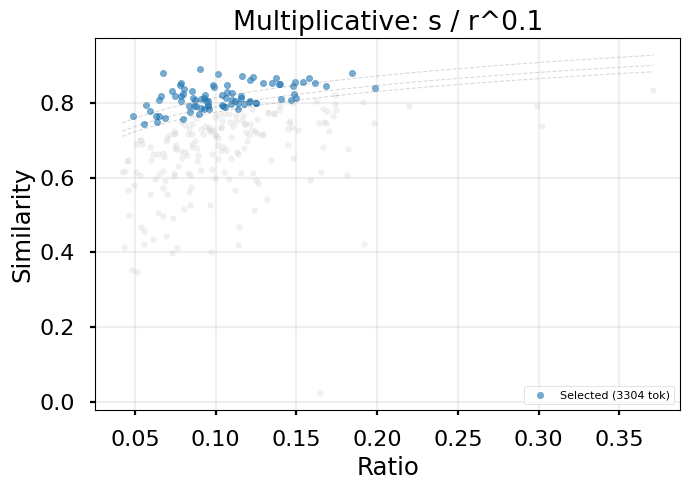

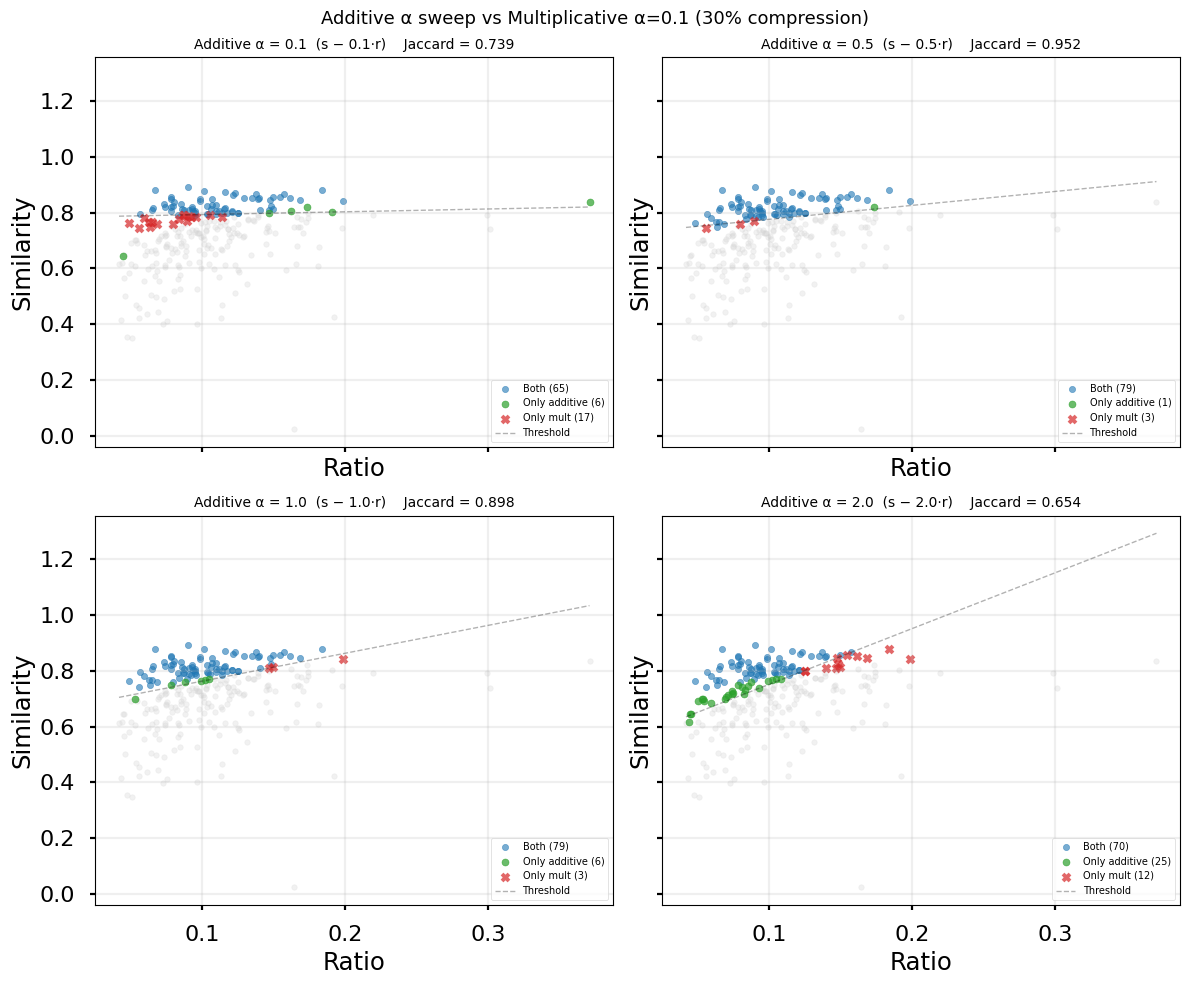

Additive α   Overlap   Only mult   Only add   Jaccard

-------------------------------------------------------

0.1        65          17          6     0.739

0.5        79           3          1     0.952

1.0        79           3          6     0.898

2.0        70          12         25     0.654

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Reference: multiplicative α=0.1
alpha_mult = 0.1
safe_ratios = np.maximum(result['ratios'], 1e-9)
scores_mult = result['similarities'] / np.power(safe_ratios, alpha_mult)
mask_mult = greedy_select(scores_mult, result['tokens'], objective_tokens)

# --- Standalone multiplicative plot ---
fig_mult, ax = plt.subplots(figsize=(7, 5))
ax.scatter(result['ratios'][~mask_mult], result['similarities'][~mask_mult],
           color='lightgrey', alpha=0.3, s=15)
ax.scatter(result['ratios'][mask_mult], result['similarities'][mask_mult],
           color='tab:blue', alpha=0.6, s=20,
           label=f'Selected ({int(np.sum(result["tokens"][mask_mult]))} tok)')
# Iso-score contours
r_grid = np.linspace(result['ratios'].min(), result['ratios'].max(), 200)
for q in [0.0, 0.25, 0.5]:
    thr = np.quantile(scores_mult[mask_mult], q)
    ax.plot(r_grid, thr * np.power(np.maximum(r_grid, 1e-9), alpha_mult),
            'k--', alpha=0.15, linewidth=0.8)
ax.set_xlabel("Ratio")
ax.set_ylabel("Similarity")
ax.set_title(f"Multiplicative: s / r^{alpha_mult}")
ax.legend(loc='lower right', fontsize=8, frameon=True)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# --- 2×2 additive α sweep ---
additive_alphas = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes_flat = axes.flatten()

overlaps = []
for i, alpha_add in enumerate(additive_alphas):
    ax = axes_flat[i]
    scores_add = result['similarities'] - alpha_add * result['ratios']
    mask_add = greedy_select(scores_add, result['tokens'], objective_tokens)

    overlap = (mask_mult & mask_add).sum()
    only_m = (mask_mult & ~mask_add).sum()
    only_a = (~mask_mult & mask_add).sum()
    overlaps.append((alpha_add, overlap, only_m, only_a))

    neither = ~mask_mult & ~mask_add
    ax.scatter(result['ratios'][neither], result['similarities'][neither],
               color='lightgrey', alpha=0.3, s=15)
    ax.scatter(result['ratios'][mask_mult & mask_add], result['similarities'][mask_mult & mask_add],
               color='tab:blue', alpha=0.6, s=20, label=f'Both ({overlap})')
    ax.scatter(result['ratios'][mask_add & ~mask_mult], result['similarities'][mask_add & ~mask_mult],
               color='tab:green', alpha=0.7, s=25, label=f'Only additive ({only_a})')
    ax.scatter(result['ratios'][mask_mult & ~mask_add], result['similarities'][mask_mult & ~mask_add],
               color='tab:red', alpha=0.7, s=25, marker='x', label=f'Only mult ({only_m})')

    # Threshold: use the highest score among non-selected sentences as the
    # decision boundary.  This is the "best sentence that didn't make it"
    # and visually separates selected from rejected better than the
    # minimum selected score (which can be dragged down by greedy tail-fill).
    non_selected_scores = scores_add[~mask_add]
    threshold = np.max(non_selected_scores) if non_selected_scores.size > 0 else np.min(scores_add)

    r_grid = np.linspace(result['ratios'].min(), result['ratios'].max(), 200)
    ax.plot(r_grid, threshold + alpha_add * r_grid, 'k--', alpha=0.3, linewidth=1,
            label='Threshold')

    ax.set_xlabel("Ratio")
    ax.set_ylabel("Similarity")
    jaccard = overlap / (overlap + only_m + only_a)
    ax.set_title(f"Additive α = {alpha_add}  (s − {alpha_add}·r)    Jaccard = {jaccard:.3f}", fontsize=10)
    ax.legend(loc='lower right', fontsize=7, frameon=True)
    ax.grid(True, alpha=0.2)

fig.suptitle("Additive α sweep vs Multiplicative α=0.1 (30% compression)", fontsize=13)
plt.tight_layout()
plt.show()

# Print overlap summary
print(f"\n{'Additive α':>12s}  {'Overlap':>8s}  {'Only mult':>10s}  {'Only add':>9s}  {'Jaccard':>8s}")
print("-" * 55)
for alpha_add, overlap, only_m, only_a in overlaps:
    jaccard = overlap / (overlap + only_m + only_a)
    print(f"{alpha_add:>12.1f}  {overlap:>8d}  {only_m:>10d}  {only_a:>9d}  {jaccard:>8.3f}")

## A/B: Additive α=0.5 vs α=0 (pure similarity)

Run the same ROUGE evaluation on 50 GovReport docs, but using the additive formula `score = similarity - α × ratio` with α=0.5 (equivalent to multiplicative α=0.1).

In [214]:
from rouge_score import rouge_scorer
import pandas as pd
import numpy as np

def compare_additive_bias(
    dataset,
    processor,
    objective_percentage: float = 0.3,
    alphas: list[float] = [0.0, 0.5],
):
    """Compare additive length_bias values: score = similarity - α × ratio."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    records = []

    for i, example in enumerate(dataset):
        text = example["report"]
        reference = example["summary"]

        # Compute features once per document
        features = processor.compute_document_features(text)
        total_tokens = int(np.sum(features["tokens"]))
        budget = total_tokens * objective_percentage

        row = {"doc": i}

        for alpha in alphas:
            scores = features["similarities"] - alpha * features["ratios"]

            # Greedy fill
            mask = np.zeros(len(scores), dtype=bool)
            current = 0
            for idx in np.argsort(-scores):
                if current + features["tokens"][idx] > budget:
                    continue
                mask[idx] = True
                current += features["tokens"][idx]

            selected_text = processor.select_sentences_with_separators(
                features["sentences"], mask.astype(int)
            )

            rouge = scorer.score(reference, selected_text)
            prefix = f"a{alpha}"
            row[f"{prefix}_tokens"] = int(np.sum(features["tokens"][mask]))
            row[f"{prefix}_rouge1"] = rouge["rouge1"].fmeasure
            row[f"{prefix}_rouge2"] = rouge["rouge2"].fmeasure
            row[f"{prefix}_rougeL"] = rouge["rougeL"].fmeasure

        records.append(row)
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} reports...")

    return pd.DataFrame(records)

df_add = compare_additive_bias(
    dataset=govreport,
    processor=processor,
    objective_percentage=0.3,
    alphas=[0.0, 0.5],
)

Processed 10/50 reports...

Processed 20/50 reports...

Processed 30/50 reports...

Processed 40/50 reports...

Processed 50/50 reports...

In [215]:
# Summary: additive α=0.5 vs α=0
summary_add = pd.DataFrame({
    "α = 0 (similarity only)": {
        "ROUGE-1": df_add["a0.0_rouge1"].mean(),
        "ROUGE-2": df_add["a0.0_rouge2"].mean(),
        "ROUGE-L": df_add["a0.0_rougeL"].mean(),
        "Avg tokens": df_add["a0.0_tokens"].mean(),
    },
    "Additive α = 0.5": {
        "ROUGE-1": df_add["a0.5_rouge1"].mean(),
        "ROUGE-2": df_add["a0.5_rouge2"].mean(),
        "ROUGE-L": df_add["a0.5_rougeL"].mean(),
        "Avg tokens": df_add["a0.5_tokens"].mean(),
    },
})
summary_add["Δ (α=0.5 − α=0)"] = summary_add["Additive α = 0.5"] - summary_add["α = 0 (similarity only)"]

print(f"Additive A/B over {len(df_add)} reports at 30% compression\n")
print(summary_add.to_string(float_format=lambda x: f"{x:.4f}"))

# Win rates
print(f"\n--- Win rates (additive α=0.5 > α=0) ---")
for metric in ["rouge1", "rouge2", "rougeL"]:
    wins = (df_add[f"a0.5_{metric}"] > df_add[f"a0.0_{metric}"]).sum()
    losses = (df_add[f"a0.5_{metric}"] < df_add[f"a0.0_{metric}"]).sum()
    ties = (df_add[f"a0.5_{metric}"] == df_add[f"a0.0_{metric}"]).sum()
    print(f"  {metric.upper():8s}: α=0.5 wins {wins}, α=0 wins {losses}, ties {ties}")

# Compare with multiplicative results (from earlier df)
print(f"\n--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---")
print(f"{'Metric':>10s}  {'Mult α=0.1':>12s}  {'Add α=0.5':>12s}  {'Δ':>8s}")
print("-" * 48)
for metric in ["rouge1", "rouge2", "rougeL"]:
    mult_val = df[f"a0.1_{metric}"].mean()
    add_val = df_add[f"a0.5_{metric}"].mean()
    print(f"  {metric.upper():8s}  {mult_val:>12.4f}  {add_val:>12.4f}  {add_val - mult_val:>+8.4f}")

Additive A/B over 50 reports at 30% compression

α = 0 (similarity only)  Additive α = 0.5  Δ (α=0.5 − α=0)
ROUGE-1                      0.3465            0.3475           0.0010
ROUGE-2                      0.1639            0.1649           0.0010
ROUGE-L                      0.1609            0.1638           0.0029
Avg tokens                2580.9600         2581.1400           0.1800

--- Win rates (additive α=0.5 > α=0) ---

ROUGE1  : α=0.5 wins 27, α=0 wins 22, ties 1

ROUGE2  : α=0.5 wins 26, α=0 wins 23, ties 1

ROUGEL  : α=0.5 wins 32, α=0 wins 17, ties 1

--- Cross-comparison: Additive α=0.5 vs Multiplicative α=0.1 ---

Metric    Mult α=0.1     Add α=0.5         Δ

------------------------------------------------

ROUGE1          0.3475        0.3475   -0.0000

ROUGE2          0.1652        0.1649   -0.0003

ROUGEL          0.1638        0.1638   -0.0000